In [206]:
import json
from collections import defaultdict
from pprint import pprint
import math
import os
import datetime

import pandas
import numpy as np
import seaborn as sns

In [207]:
def distance(point1, point2):
    return math.sqrt(sum([(a - b) ** 2 for a, b in zip(point1, point2)]))

In [208]:
# for all files in the directory and subdirectories
tests = []

for root, dirs, files in os.walk("../macros/tests"):
    for file in files:
        if file.endswith(".json"):
            with open(os.path.join(root, file), 'r') as f:
                test = json.load(f)
                test['name'] = file
                tests.append(test)
                   


In [209]:
def get_attribute_tree(value):
    attributes = {}
    for k, v in value.items():
        if isinstance(v, dict):
            attr = get_attribute_tree(v)
            for a, b in attr.items():
                attributes[k + '.' + a] = b
        else:
            attributes[k] = v
    
    return attributes

In [210]:
tests_ = []
for test in tests:
    if 'tests' not in test:
        continue
    for t in test['tests']:    
        test_ = {
            'header.name': test['name'],
            'header.type': test['type'],
        }
        test_.update(get_attribute_tree(t))
        tests_.append(test_)

In [211]:
len(tests_)

147

In [212]:
tests = [test_ for test_ in tests_ if test_['header.type'] == 'craft']
len(tests)

36

In [213]:
for test in tests:
    if 'log' in test:
        del test['log']

In [214]:
tests[0]

{'header.name': '2023-09-17_16-30-31.json',
 'header.type': 'craft',
 'endPos': [5539.383, 64, -75.34186],
 'timeStart': 1694979070.0,
 'biome': 'Stone Shore',
 'traceback': "@D:\\GitHub\\autocraft\\macros\\libs\\walk.lua:527 Path not found\nstack traceback:\n\tD:\\GitHub\\autocraft\\macros\\libs\\walk.lua:527: in function 'walkTo'\n\tD:\\GitHub\\autocraft\\macros\\libs\\action.lua:199: in function 'buildWorkbench'\n\tD:\\GitHub\\autocraft\\macros\\libs\\crafting.lua:243: in function 'craftingTable'\n\tD:\\GitHub\\autocraft\\macros\\libs\\crafting.lua:370: in function 'craft'\n\tD:\\GitHub\\autocraft\\macros\\libs\\command.lua:190: in function <D:\\GitHub\\autocraft\\macros\\libs\\command.lua:176>\n\t[Java]: in function 'pcall'\n\tD:\\GitHub\\autocraft\\macros\\libs\\command.lua:72: in function <D:\\GitHub\\autocraft\\macros\\libs\\command.lua:71>\n\t[Java]: in ?",
 'status': False,
 'timeTaken': 108.125,
 'error': 'Path not found',
 'startPos': [5540.665, 0, -30.286892],
 'world.moonP

In [215]:
df = pandas.DataFrame(tests)                        
df.sort_values(by=['timeStart'], inplace=True)
df.reset_index(inplace=True, drop=True)

In [216]:
df['timeStart'] = pandas.to_datetime(df['timeStart'], unit='s')
df['timeEnd'] = pandas.to_datetime(df['timeEnd'], unit='s')

In [217]:
df.shape

(36, 35)

In [218]:
df = df[df['timeStart'] > datetime.datetime(2023, 10, 1, 0, 0, 0)]

In [219]:
df.shape

(30, 35)

In [220]:
df['error'].fillna('', inplace=True)

In [221]:
df.loc[df['error'].str.contains('nil'), 'error'] = 'Code error'
df.loc[df['error'].str.contains('attempt'), 'error'] = 'Code error'
df.loc[df['error'].str.startswith('@'), 'error'] = 'Code error'

In [222]:
df['distance'] = df.apply(lambda x: distance(x['startPos'], x['endPos']), axis=1)
df['distance_roll'] = df['distance'].rolling(10).mean()

In [223]:
df['blocks_per_second'] = df['distance'] / df['timeTaken']
df = df[df['blocks_per_second'] < 100] # remove outliers (teleports)
df['blocks_per_second_roll'] = df['blocks_per_second'].rolling(10).mean()

In [224]:
df.head()

,header.name,header.type,endPos,timeStart,biome,traceback,status,timeTaken,error,startPos,...,world.name,world.seed,world.isRemote,world.clearWeatherTime,world.spawn,timeEnd,distance,distance_roll,blocks_per_second,blocks_per_second_roll
6,2023-10-12_00-11-04.json,craft,"[13581.768, 65, 15509.5]",2023-10-12 03:12:00,Forest,@D:\GitHub\autocraft\macros\libs\crafting.lua:...,False,87.436,Code error,"[13588.463, 0, 15512.258]",...,MpServer,6889688615036750848,True,0,"[240, 70, 241]",2023-10-12 03:14:10,65.402061,NaN,0.747999,NaN
8,2023-10-12_00-11-04.json,craft,"[7364.4004, 98, 337.43738]",2023-10-12 03:12:00,Mountains,NaN,True,51.088,,"[7370.699, 0, 346.3]",...,MpServer,6889688615036750848,True,0,"[240, 70, 241]",2023-10-12 03:12:00,98.601310,NaN,1.930029,NaN
9,2023-10-12_00-11-04.json,craft,"[13588.463, 69, 6961.2583]",2023-10-12 03:12:00,River,@D:\GitHub\autocraft\macros\libs\crafting.lua:...,False,42.714,Code error,"[13579.4, 0, 6940.4375]",...,MpServer,6889688615036750848,True,0,"[240, 70, 241]",2023-10-12 03:12:00,72.640510,NaN,1.700625,NaN
10,2023-10-12_00-11-04.json,craft,"[22666.527, 62, 15505.3]",2023-10-12 03:14:10,Swamp,@D:\GitHub\autocraft\macros\libs\crafting.lua:...,False,300.201,Timeout,"[22667.768, 0, 15509.5]",...,MpServer,6889688615036750848,True,0,"[240, 70, 241]",2023-10-12 03:20:30,62.154486,NaN,0.207043,NaN
11,2023-10-12_00-11-04.json,craft,"[22689.52, 73, 21280.453]",2023-10-12 03:20:30,Sunflower Plains,@D:\GitHub\autocraft\macros\libs\crafting.lua:...,False,300.203,Timeout,"[22666.527, 0, 21308.3]",...,MpServer,6889688615036750848,True,0,"[240, 70, 241]",2023-10-12 03:24:50,81.444051,NaN,0.271297,NaN


Text(0.5, 0, 'Test')

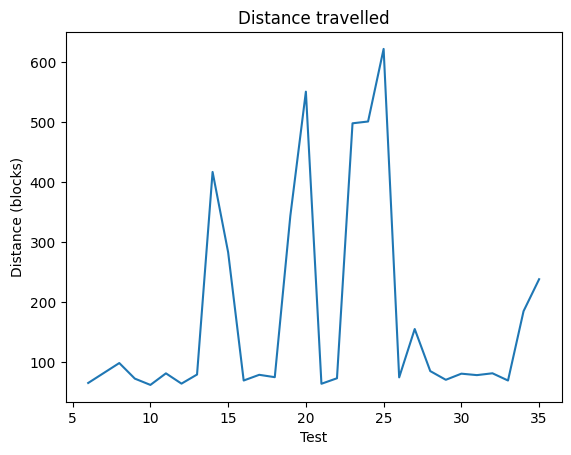

In [225]:
fig = sns.lineplot(x=df.index, y='distance', data=df)
fig.set_title('Distance travelled')
fig.set_ylabel('Distance (blocks)')
fig.set_xlabel('Test')

In [226]:
print('Average distance travelled: {:.2f} blocks'.format(df['distance'].mean()))

Average distance travelled: 180.00 blocks


Text(0.5, 0, 'Test')

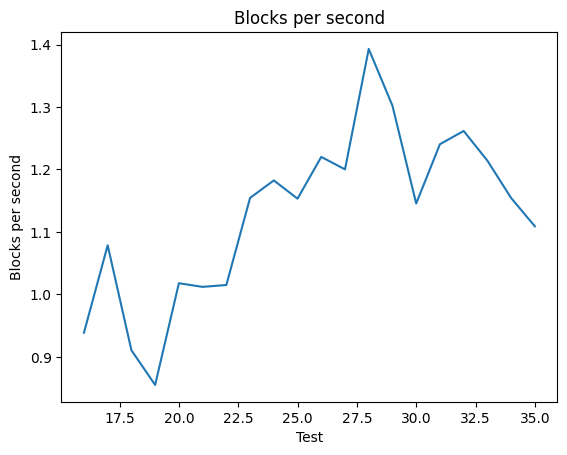

In [227]:
# add blocks per second
fig = sns.lineplot(x=df.index, y='blocks_per_second_roll', data=df)
fig.set_title('Blocks per second')
fig.set_ylabel('Blocks per second')
fig.set_xlabel('Test')

23 errors out of 29 tests


<AxesSubplot: title={'center': 'Errors'}, ylabel='error'>

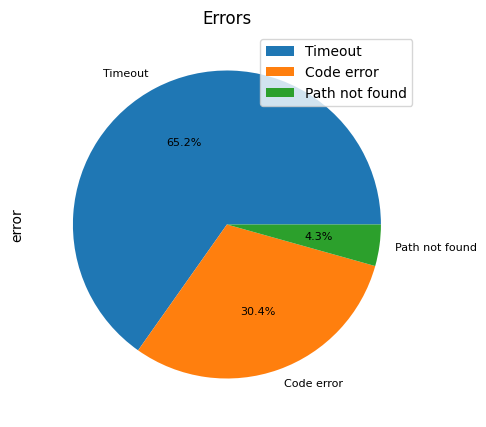

In [232]:
# pie chart of errors
error = df[df['error'] != '' ]['error']
print(f'{len(error)} errors out of {len(df)} tests')
error.value_counts().plot.pie(
    autopct='%1.1f%%',
    figsize=(5, 5),
    title='Errors',
    fontsize=8,
    legend=True,
)

In [230]:
code = df[df['error'] == 'Code error']
print('Code errors: ', len(code))
for i in code['traceback']:
    print(i)

Code errors:  7
@D:\GitHub\autocraft\macros\libs\crafting.lua:403 @D:\GitHub\autocraft\macros\libs\crafting.lua:403 @D:\GitHub\autocraft\macros\libs\walk.lua:538 Player taking too long to break blocks
stack traceback:
	D:\GitHub\autocraft\macros\libs\walk.lua:538: in function 'walkTo'
	D:\GitHub\autocraft\macros\libs\gathering/wood.lua:30: in function 'cutTree'
	D:\GitHub\autocraft\macros\libs\gathering/wood.lua:52: in function '?'
	D:\GitHub\autocraft\macros\libs\crafting.lua:374: in function <D:\GitHub\autocraft\macros\libs\crafting.lua:368>
	[Java]: in function 'pcall'
	D:\GitHub\autocraft\macros\libs\crafting.lua:390: in function <D:\GitHub\autocraft\macros\libs\crafting.lua:368>
	[Java]: in function 'pcall'
	D:\GitHub\autocraft\macros\libs\crafting.lua:390: in function 'craft'
	D:\GitHub\autocraft\macros\libs\command.lua:190: in function <D:\GitHub\autocraft\macros\libs\command.lua:176>
	[Java]: in function 'pcall'
	D:\GitHub\autocraft\macros\libs\command.lua:72: in function <D:\G